In [203]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [204]:
%reload_ext Cython

In [205]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [206]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mtp


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



np.random.seed(seed = 0)

In [5]:
name1 = 'stats_mean_std/seq_1_8_mean_std.csv'
name2 = 'stats_mean_std/seq_9_16_mean_std.csv'

tab1 = pd.read_csv(name1, index_col = 0, header = [0,1] )
tab2 = pd.read_csv(name2, index_col = 0, header = [0,1] )
controls = pd.read_pickle('controls.p')


In [273]:
columns_to_match = ['MBR_GNDR','AGE_AT_MIDMONTH', 'ALLOW_AMT', 'ACUTE6', 'LOB', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_DIABETES','CC_TOBACCO', 'CC_DX_CNT']

columns_to_match2 = ['CC_ADHD','CC_ANXIETY_DISORDER',
                    "CC_BIPOLAR", 'CC_DEPRESSION', 
                    'CC_DEPRESSIVE_DISORDERS','CC_LEARN_DISAB',
                   'CC_PERSONALITY','CC_PTSD', 'CC_SCHIZOPHRENIA',
                   'CC_SCHIZOPHRENIA_OTHER']

In [6]:
controls.drop(columns = ['PERS_ID', "MYR"], inplace = True)
Nc = len(controls)

In [7]:
stats = controls.describe().T[['mean', 'std']]
pooled = (111*tab1.Treated['std']+ Nc*stats['std'])/(111+Nc)

In [41]:
sdmeans1 = tab1.loc[:,(slice(None),'mean')].divide(pooled.values, axis = 0).droplevel(1,axis = 1)
sdmeans2 = tab2.loc[:,(slice(None),'mean')].divide(pooled.values, axis = 0).droplevel(1,axis = 1)

In [78]:
sdmeans1

Treated  Unmatched Controls      seq1      seq2      seq3      seq4  Unmatched Med_Controls      seq5      seq6      seq7      seq8
MBR_GNDR                    0.690699            0.879866  0.693197  0.690051  0.691521  0.691932                0.800109  0.695713  0.692854  0.690423  0.695541
AGE_AT_MIDMONTH             1.897534            2.409364  1.932482  1.924287  1.914420  1.916553                1.705482  1.925403  1.918313  1.916902  1.914589
ALLOW_AMT                   0.163817            0.238038  0.181328  0.172510  0.188380  0.191204                0.190029  0.176499  0.158235  0.182784  0.181541
ALLOW_ER                    0.137107            0.124112  0.153301  0.127733  0.097458  0.113779                0.143245  0.170405  0.169768  0.150484  0.176805
ALLOW_IP                    0.083945            0.074881  0.021629  0.015080  0.029306  0.023792                0.057968  0.035913  0.022103  0.041881  0.041578
CC_ADHD                     1.126161            0.204516  0.379759  0.464121  0.433159  0.425699                0.428622  0.526332  0.559772  0.617890  0.535731
CC_ALZHEIMER                0.117983            0.071575  0.000000  0.000000  0.000000  0.000000                0.008843  0.000000  0.000000  0.000000  0.012992
CC_ALZHEIMER_PLUS           0.265590            0.127883  0.039983  0.047180  0.013880  0.035450                0.052533  0.120383  0.090516  0.070058  0.095051
CC_AMI                      0.309469            0.056229  0.062118  0.039267  0.064691  0.016523                0.041560  0.093515  0.097358  0.065306  0.051118
CC_ANEMIA                   0.609128            0.266918  0.264910  0.321183  0.282960  0.292698                0.267179  0.409033  0.415197  0.378485  0.398733
CC_ANXIETY_DISORDER         2.126370            0.523055  0.938987  0.969147  0.920106  0.926398                0.695348  1.165143  1.122718  1.108340  1.056034
CC_ARTHRITIS                0.405049            0.381312  0.284560  0.308371  0.275182  0.297357                0.222854  0.433489  0.369007  0.379300  0.328952
CC_ASTHMA                   0.883071            0.236839  0.323679  0.391686  0.353142  0.371035                0.362849  0.564628  0.579779  0.559054  0.532722
CC_ATRIAL_FIB               0.199560            0.170237  0.030042  0.053175  0.093861  0.058601                0.043835  0.030151  0.052317  0.052641  0.065926
CC_AUTISM                   0.451108            0.080434  0.090548  0.125927  0.070725  0.066234                0.203347  0.181753  0.201049  0.166593  0.149027
CC_BIPOLAR                  2.184229            0.187633  0.486081  0.503687  0.456590  0.438586                0.433519  0.841772  0.806654  0.651315  0.661444
CC_BPH                      0.052121            0.161266  0.020924  0.031744  0.098057  0.050090                0.039393  0.031499  0.038260  0.032996  0.037307
CC_BREAST_CANCER            0.067491            0.125036  0.081282  0.078785  0.042325  0.064861                0.037098  0.040788  0.042465  0.042727  0.070604
CC_CATARACT                 0.000000            0.242237  0.064151  0.057675  0.074232  0.073942                0.066765  0.100152  0.065167  0.044962  0.082119
CC_CEREBRAL_PALSY           0.000000            0.029436  0.000000  0.015482  0.063764  0.081430                0.048268  0.000000  0.063975  0.128740  0.067180
CC_CHRONIC_KIDNEY           0.867518            0.314783  0.290218  0.308213  0.259929  0.242396                0.228189  0.367002  0.403312  0.292911  0.292959
CC_COLORECTAL_CANCER        0.141845            0.057748  0.113886  0.043196  0.059302  0.053013                0.022150  0.057150  0.052061  0.059866  0.046859
CC_COPD                     0.682019            0.192787  0.091265  0.120000  0.038018  0.072827                0.182236  0.338905  0.252705  0.191899  0.225310
CC_CYSTIC_FIBROSIS          0.000000            0.049015  0.070923  0.026900  0.073861  0.075460                0.052969  0.000000  0.027790  0.074563  0.087545
CC_D

In [275]:
sdmeans1.loc[columns_to_match].round(2)

Treated  Unmatched Controls  seq1  seq2  seq3  seq4  Unmatched Med_Controls  seq5  seq6  seq7  seq8
MBR_GNDR            0.69                0.88  0.69  0.69  0.69  0.69                    0.80  0.70  0.69  0.69  0.70
AGE_AT_MIDMONTH     1.90                2.41  1.93  1.92  1.91  1.92                    1.71  1.93  1.92  1.92  1.91
ALLOW_AMT           0.16                0.24  0.18  0.17  0.19  0.19                    0.19  0.18  0.16  0.18  0.18
ACUTE6              2.90                0.31  0.56  0.58  0.44  0.47                    0.58  1.15  1.05  0.78  0.89
LOB                 0.00                1.80  1.53  1.51  1.55  1.51                    0.00  0.00  0.00  0.00  0.00
CC_PRESSURE         0.00                0.10  0.05  0.10  0.12  0.08                    0.07  0.16  0.15  0.09  0.11
CC_OBESITY          0.73                0.56  0.76  0.74  0.75  0.74                    0.53  0.84  0.76  0.79  0.77
CC_HYPERTENSION     0.64                0.61  0.36  0.40  0.45  0.40                    0.34  0.48  0.48  0.47  0.45
CC_DIABETES         0.54                0.37  0.36  0.38  0.31  0.29                    0.28  0.47  0.45  0.38  0.36
CC_TOBACCO          1.99                0.32  0.52  0.54  0.48  0.51                    0.63  1.00  1.02  0.97  0.93
CC_DX_CNT           2.44                0.94  1.01  1.08  1.02  1.00                    0.86  1.43  1.37  1.27  1.25

In [52]:
sdmeandiff1 = np.abs(sdmeans1.loc[:,'Unmatched Controls':].subtract(sdmeans1['Treated'].values, axis = 0))
sdmeandiff2 = np.abs(sdmeans2.loc[:,'Unmatched Controls':].subtract(sdmeans2['Treated'].values, axis = 0))

In [272]:
sdmeandiff1

Unmatched Controls      seq1      seq2      seq3      seq4  Unmatched Med_Controls      seq5      seq6      seq7      seq8
MBR_GNDR                              0.189167  0.002498  0.000648  0.000822  0.001233                0.109410  0.005014  0.002155  0.000276  0.004842
AGE_AT_MIDMONTH                       0.511831  0.034948  0.026754  0.016887  0.019019                0.192052  0.027869  0.020779  0.019368  0.017055
ALLOW_AMT                             0.074221  0.017511  0.008693  0.024564  0.027388                0.026213  0.012682  0.005581  0.018968  0.017725
ALLOW_ER                              0.012995  0.016194  0.009374  0.039649  0.023328                0.006138  0.033298  0.032661  0.013377  0.039698
ALLOW_IP                              0.009064  0.062316  0.068865  0.054639  0.060153                0.025977  0.048032  0.061842  0.042064  0.042367
CC_ADHD                               0.921645  0.746403  0.662041  0.693003  0.700463                0.697539  0.599829  0.566389  0.508271  0.590430
CC_ALZHEIMER                          0.046408  0.117983  0.117983  0.117983  0.117983                0.109140  0.117983  0.117983  0.117983  0.104991
CC_ALZHEIMER_PLUS                     0.137707  0.225608  0.218411  0.251711  0.230140                0.213057  0.145207  0.175074  0.195532  0.170539
CC_AMI                                0.253240  0.247351  0.270201  0.244778  0.292946                0.267909  0.215954  0.212111  0.244163  0.258351
CC_ANEMIA                             0.342210  0.344218  0.287946  0.326168  0.316430                0.341949  0.200095  0.193931  0.230643  0.210395
CC_ANXIETY_DISORDER                   1.603316  1.187384  1.157224  1.206265  1.199972                1.431022  0.961227  1.003653  1.018030  1.070336
CC_ARTHRITIS                          0.023737  0.120489  0.096678  0.129867  0.107692                0.182195  0.028440  0.036042  0.025749  0.076097
CC_ASTHMA                             0.646232  0.559392  0.491385  0.529929  0.512036                0.520222  0.318444  0.303292  0.324017  0.350349
CC_ATRIAL_FIB                         0.029323  0.169518  0.146385  0.105699  0.140959                0.155724  0.169408  0.147242  0.146919  0.133634
CC_AUTISM                             0.370675  0.360560  0.325182  0.380384  0.384874                0.247762  0.269355  0.250059  0.284516  0.302081
CC_BIPOLAR                            1.996596  1.698148  1.680542  1.727639  1.745643                1.750710  1.342457  1.377575  1.532914  1.522785
CC_BPH                                0.109146  0.031197  0.020376  0.045937  0.002031                0.012728  0.020621  0.013861  0.019124  0.014814
CC_BREAST_CANCER                      0.057545  0.013791  0.011295  0.025166  0.002630                0.030393  0.026702  0.025026  0.024764  0.003113
CC_CATARACT                           0.242237  0.064151  0.057675  0.074232  0.073942                0.066765  0.100152  0.065167  0.044962  0.082119
CC_CEREBRAL_PALSY                     0.029436  0.000000  0.015482  0.063764  0.081430                0.048268  0.000000  0.063975  0.128740  0.067180
CC_CHRONIC_KIDNEY                     0.552735  0.577299  0.559305  0.607589  0.625122                0.639329  0.500515  0.464206  0.574607  0.574558
CC_COLORECTAL_CANCER                  0.084097  0.027959  0.098649  0.082542  0.088832                0.119695  0.084695  0.089784  0.081979  0.094985
CC_COPD                               0.489232  0.590754  0.562018  0.644000  0.609191                0.499783  0.343114  0.429314  0.490120  0.456709
CC_CYSTIC_FIBROSIS                    0.049015  0.070923  0.026900  0.073861  0.075460                0.052969  0.000000  0.027790  0.074563  0.087545
CC_DEPRESSION                         1.481910  1.143382  1.081146  1.173916  1.131881                1.292735  0.837224  0.883516  0.904826  0.946079
CC_DEPRESSIVE_DISORDERS               1.361261  1.243697  1.198990  1.185712  1.269736                

In [280]:
mapper = {'seq1': 'Rig', 'seq2':'NonRig', 'seq3':'Rig6', 'seq4':'NonRig6', 'seq5':'Rig-Med', 'seq6':'NonRig-Med', 'seq7':'Rig-Med6',
         'seq8':'NonRig-Med6'}

In [281]:
sdmeandiff1.loc[columns_to_match].rename(mapper = mapper, axis = 1).round(2)

Unmatched Controls   Rig  NonRig  Rig6  NonRig6  Unmatched Med_Controls  Rig-Med  NonRig-Med  Rig-Med6  NonRig-Med6
MBR_GNDR                       0.19  0.00    0.00  0.00     0.00                    0.11     0.01        0.00      0.00         0.00
AGE_AT_MIDMONTH                0.51  0.03    0.03  0.02     0.02                    0.19     0.03        0.02      0.02         0.02
ALLOW_AMT                      0.07  0.02    0.01  0.02     0.03                    0.03     0.01        0.01      0.02         0.02
ACUTE6                         2.59  2.34    2.32  2.45     2.43                    2.32     1.75        1.84      2.12         2.00
LOB                            1.80  1.53    1.51  1.55     1.51                    0.00     0.00        0.00      0.00         0.00
CC_PRESSURE                    0.10  0.05    0.10  0.12     0.08                    0.07     0.16        0.15      0.09         0.11
CC_OBESITY                     0.16  0.04    0.02  0.03     0.01                    0.19     0.11        0.04      0.07         0.04
CC_HYPERTENSION                0.04  0.29    0.25  0.20     0.24                    0.30     0.17        0.16      0.17         0.20
CC_DIABETES                    0.17  0.18    0.16  0.23     0.24                    0.26     0.07        0.09      0.16         0.17
CC_TOBACCO                     1.67  1.47    1.45  1.51     1.48                    1.36     0.98        0.97      1.02         1.06
CC_DX_CNT                      1.50  1.43    1.36  1.42     1.44                    1.58     1.01        1.07      1.17         1.18

In [309]:
sdmeandiff1.loc[columns_to_match2].rename(mapper = mapper, axis = 1).round(2)

Unmatched Controls   Rig  NonRig  Rig6  NonRig6  Unmatched Med_Controls  Rig-Med  NonRig-Med  Rig-Med6  NonRig-Med6
CC_ADHD                                0.92  0.75    0.66  0.69     0.70                    0.70     0.60        0.57      0.51         0.59
CC_ANXIETY_DISORDER                    1.60  1.19    1.16  1.21     1.20                    1.43     0.96        1.00      1.02         1.07
CC_BIPOLAR                             2.00  1.70    1.68  1.73     1.75                    1.75     1.34        1.38      1.53         1.52
CC_DEPRESSION                          1.48  1.14    1.08  1.17     1.13                    1.29     0.84        0.88      0.90         0.95
CC_DEPRESSIVE_DISORDERS                1.36  1.24    1.20  1.19     1.27                    1.26     1.07        1.18      1.08         1.11
CC_LEARN_DISAB                         0.26  0.32    0.24  0.26     0.29                    0.16     0.22        0.20      0.32         0.30
CC_PERSONALITY                         1.36  1.20    1.14  1.20     1.18                    1.27     0.91        0.99      1.09         1.07
CC_PTSD                                2.77  2.51    2.49  2.63     2.57                    2.54     2.20        2.18      2.23         2.26
CC_SCHIZOPHRENIA                       1.21  0.99    0.98  1.15     1.07                    1.06     0.66        0.69      0.79         0.84
CC_SCHIZOPHRENIA_OTHER                 1.27  1.07    1.02  1.23     1.15                    1.11     0.68        0.76      0.93         0.91

In [63]:
cols0 =  ['seq'+str(i) for i in range(1,9)]
cols = ['seq'+str(i) for i in range(9,17)]
mapper = dict(zip(cols0, cols))
sdmeandiff2.rename(mapper,axis = 1, inplace = True)

In [64]:
sdmdiff = pd.concat((sdmeandiff1,sdmeandiff2[cols]), axis = 1)

In [167]:
plt.style.use('seaborn-paper')
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


### STD MEANS Graph

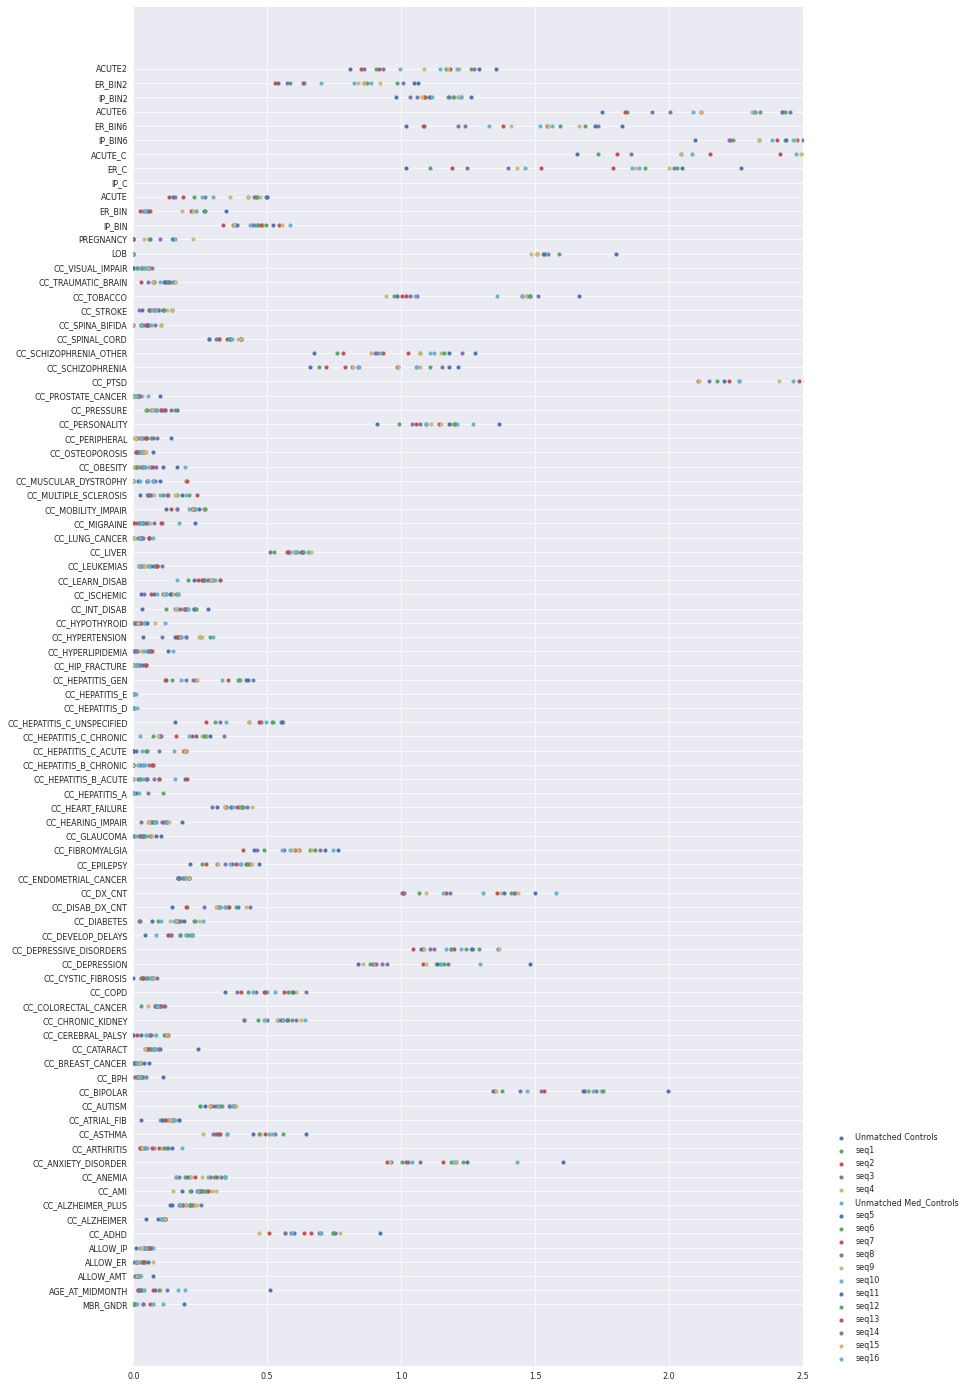

In [168]:
fig, ax = plt.subplots(figsize = (12,25))
for col in sdmdiff.columns:
    ax.scatter(x= sdmdiff[col].iloc[:].values, y = np.arange(1, len(sdmdiff)+1), s = s)
    
ax.set_yticks(np.arange(1, len(sdmdiff)+1))
ax.set_yticklabels(list(sdmdiff.index))
ax.set_xlim((0,2.5))
ax.legend(sdmdiff.columns,loc=(1.04,0))
#ax.legend(loc=(1.04,0))
fig.show()

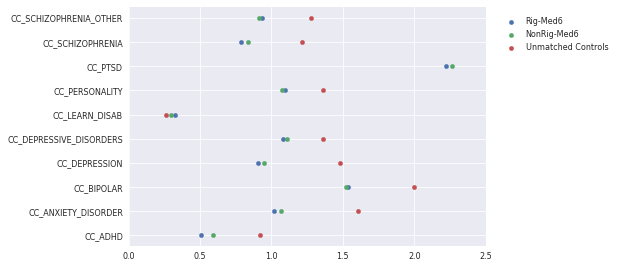

In [308]:
fig, ax = plt.subplots()
for col in ['seq7', 'seq8','Unmatched Controls']:
    ax.scatter(x= sdmdiff.loc[columns_to_match2][col].iloc[:].values, y = np.arange(1, len(sdmdiff.loc[columns_to_match2])+1), s= s)
    
ax.set_yticks(np.arange(1, len(sdmdiff.loc[columns_to_match2])+1))
ax.set_yticklabels(list(sdmdiff.loc[columns_to_match2].index))
ax.set_xlim((0,2.5))
ax.legend(['Rig-Med6', 'NonRig-Med6','Unmatched Controls'],loc=(1.04,0.8))
#ax.legend(loc=(1.04,0))
fig.show()

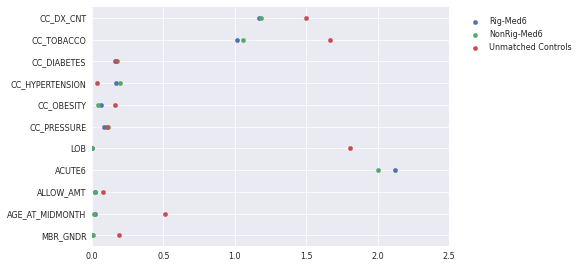

In [288]:
fig, ax = plt.subplots()
for col in ['seq7', 'seq8','Unmatched Controls']:
    ax.scatter(x= sdmdiff.loc[columns_to_match][col].iloc[:].values, y = np.arange(1, len(sdmdiff.loc[columns_to_match])+1), s= s)
    
ax.set_yticks(np.arange(1, len(sdmdiff.loc[columns_to_match])+1))
ax.set_yticklabels(list(sdmdiff.loc[columns_to_match].index))
ax.set_xlim((0,2.5))
ax.legend(['Rig-Med6', 'NonRig-Med6','Unmatched Controls'],loc=(1.04,0.8))
#ax.legend(loc=(1.04,0))
fig.show()

In [171]:
sdmdiffsel = sdmdiff.loc[columns_to_match] 

In [177]:
s = 20

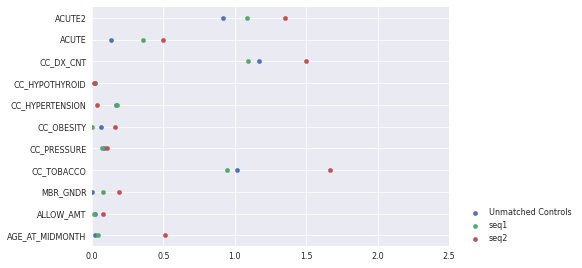

In [178]:
fig, ax = plt.subplots()
for col in ['seq7', 'seq15','Unmatched Controls']:
    ax.scatter(x= sdmdiffsel[col].iloc[:].values, y = np.arange(1, len(sdmdiffsel)+1), s = s)
    
ax.set_yticks(np.arange(1, len(sdmdiffsel)+1))
ax.set_yticklabels(list(sdmdiffsel.index))
ax.set_xlim((0,2.5))
ax.legend(sdmdiffsel.columns,loc=(1.04,0))
#ax.legend(loc=(1.04,0))
fig.show()

In [290]:
sdmeans1S = sdmeans1.loc[columns_to_match] 

In [304]:
sdmeansSS = sdmeans1.loc[columns_to_match2] 

### STD Mean Plots

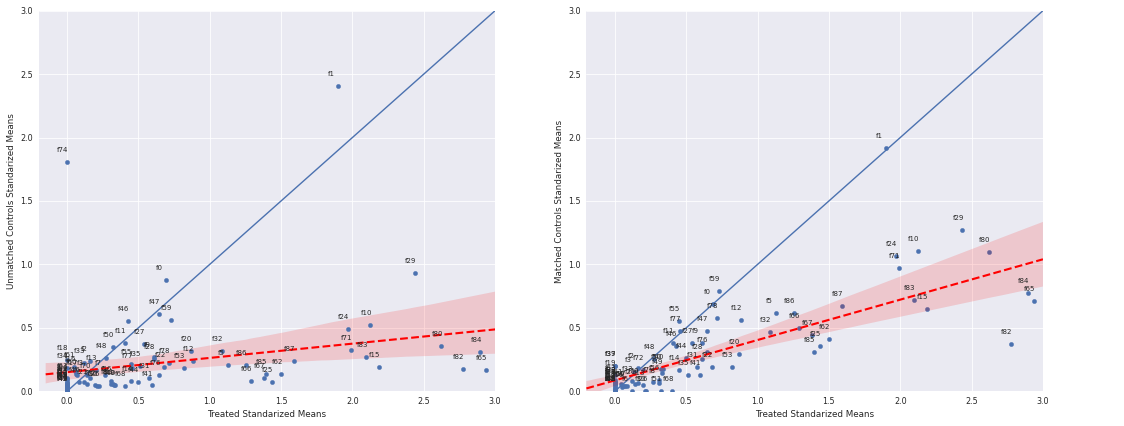

In [296]:
f, ax = plt.subplots(1,2, figsize = (18,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(sdmeans1['Treated'].values, sdmeans1['Unmatched Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].set_xlim(-0.2,3)
ax[0].set_ylim(0,3)
ax[1].set_xlim(-0.2,3)
ax[1].set_ylim(0,3)
ax[0].scatter(sdmeans1['Treated'], sdmeans1['Unmatched Controls'], s = s)
ax[1].scatter(sdmeans1['Treated'], sdmeans1['seq7'], s = s)
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(sdmeans1['Treated'].values, sdmeans1['seq7'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(sdmeans1.index)):
    ax[0].annotate('f'+str(i), (sdmeans1['Treated'].iloc[i],sdmeans1['Unmatched Controls'].iloc[i]), fontsize = 'x-small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate('f'+str(i), (sdmeans1['Treated'].iloc[i],sdmeans1['seq7'].iloc[i]),fontsize = 'x-small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.show()

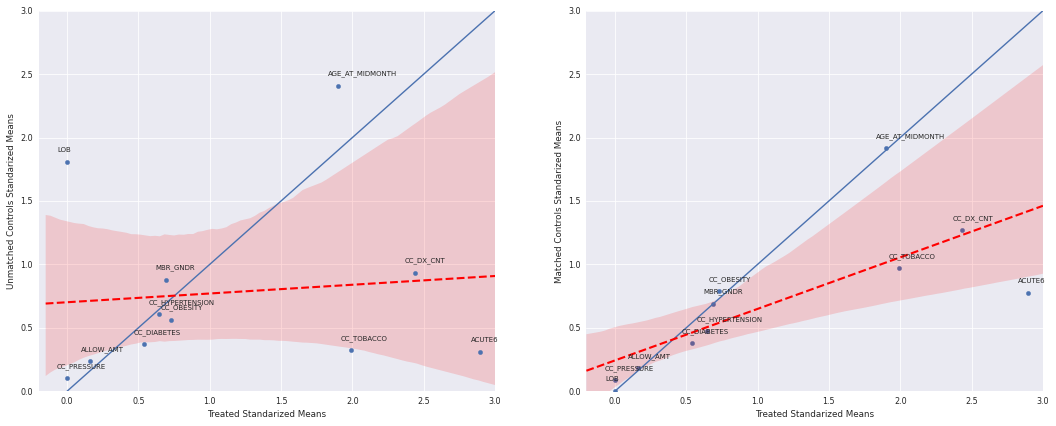

In [293]:
f, ax = plt.subplots(1,2, figsize = (18,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(sdmeans1S['Treated'].values, sdmeans1S['Unmatched Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].set_xlim(-0.2,3)
ax[0].set_ylim(0,3)
ax[1].set_xlim(-0.2,3)
ax[1].set_ylim(0,3)

ax[0].scatter(sdmeans1S['Treated'], sdmeans1S['Unmatched Controls'], s = s)
ax[1].scatter(sdmeans1S['Treated'], sdmeans1S['seq7'], s = s)
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(sdmeans1S['Treated'].values, sdmeans1S['seq7'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(sdmeans1S.index)):
    ax[0].annotate(name, (sdmeans1S['Treated'].iloc[i],sdmeans1S['Unmatched Controls'].iloc[i]), fontsize = 'x-small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (sdmeans1S['Treated'].iloc[i],sdmeans1S['seq7'].iloc[i]),fontsize = 'x-small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.show()

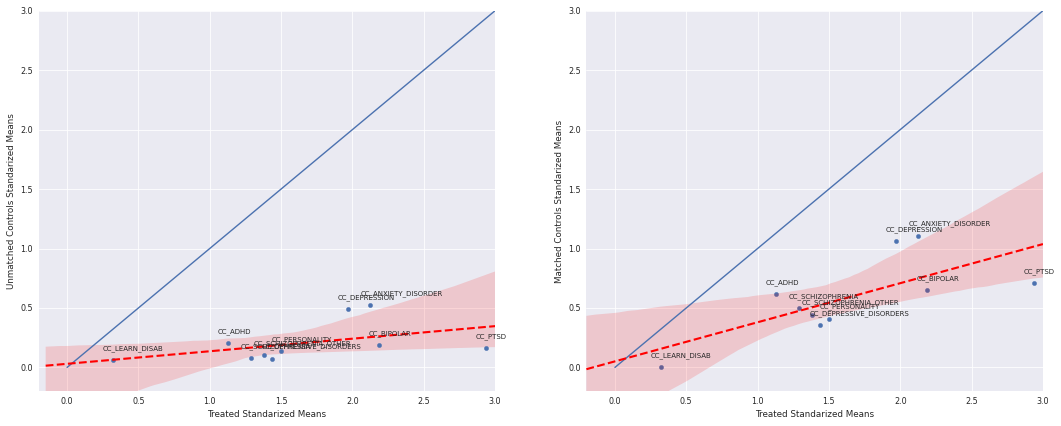

In [307]:
f, ax = plt.subplots(1,2, figsize = (18,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(sdmeansSS['Treated'].values, sdmeansSS['Unmatched Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].set_xlim(-0.2,3)
ax[0].set_ylim(-0.2,3)
ax[1].set_xlim(-0.2,3)
ax[1].set_ylim(-0.2,3)

ax[0].scatter(sdmeansSS['Treated'], sdmeansSS['Unmatched Controls'], s = s)
ax[1].scatter(sdmeansSS['Treated'], sdmeansSS['seq7'], s = s)
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(sdmeansSS['Treated'].values, sdmeansSS['seq7'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(sdmeansSS.index)):
    ax[0].annotate(name, (sdmeansSS['Treated'].iloc[i],sdmeansSS['Unmatched Controls'].iloc[i]), fontsize = 'x-small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (sdmeansSS['Treated'].iloc[i],sdmeansSS['seq7'].iloc[i]),fontsize = 'x-small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.show()

### Get distances

In [184]:
from pathlib import Path
from sklearn.neighbors import NearestNeighbors


In [187]:
latent_tr  = pd.read_pickle('treated_latent.p')

In [189]:
p =Path('latent_features')

In [257]:
order = ['seq_'+str(i) for i in range(1, 17)]
df = pd.DataFrame()
for file in order:
    
    dfss = pd.read_csv('latent_features/'+file+'.csv')
    neighs = NearestNeighbors(n_neighbors = 1)
    neighs = neighs.fit(latent_tr.loc[:,'x1':].values)
    dist, indx = neighs.kneighbors(dfss.loc[:,'x1':].values)
    dff = pd.DataFrame(dfss.PERS_ID.values, columns = ['PERS_ID_'+file]).astype(int)
    dff[file] = dist[:,0]
    df = pd.concat((df, dff), axis =1, ignore_index = False)


In [260]:
df.fillna(-1, inplace = True)

In [261]:
for column in list(df.columns):
    if 'PERS_ID' in column:
        df[column] = df[column].astype(int)

In [263]:
df.to_csv('distances.csv')